Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 06/22/23\
Last modified: 07/20/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports. The main data sources are the Black Sea Grain Initiative (BSGI) of the United
Nations and Panjiva, a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
from utils.get_data import get_data
from utils.record_linkage import record_linkage
from utils.plot import cargo_grouping, plot_line, plot_crops
from utils.clean_data import PRODUCTS_VAL, clean_column

pd.set_option('display.float_format', lambda x: '%.4f' % x)

Import cleaned data from Panjiva and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
ig = get_data("ig")
bsgi = get_data("bsgi")
panjiva = get_data("panjiva")

clean_column(panjiva, "shipment_origin")
panjiva = panjiva.loc[panjiva.loc[:, "shipment_origin"] == "ukraine"]
panjiva["product"].head()

0                      yellow peas
1                       chick peas
2                       chick peas
3    millet (feed grade) baik/baru
4                split chick peas,
Name: product, dtype: object

,year,month,weight_ton,date
0,2018,7,53.6980,7/2018
1,2018,8,29.8858,8/2018
2,2018,9,0.0000,9/2018
3,2018,10,0.0000,10/2018
4,2018,11,25.4072,11/2018
5,2018,12,61.2648,12/2018
6,2019,1,86.1588,1/2019
7,2019,2,31403.8283,2/2019
8,2019,3,20326.9354,3/2019
9,2019,4,127066.0325,4/2019


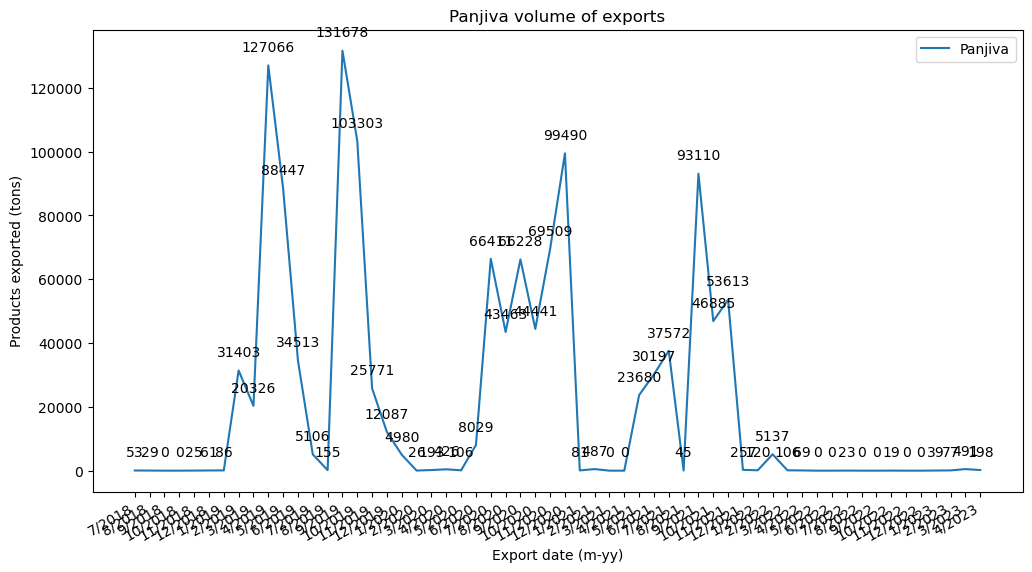

In [10]:
panjiva_g = cargo_grouping(panjiva, ["year", "month"], ["weight_ton"], ["year", "month"], True)
panjiva_g["date"] = panjiva_g["month"].astype(str) + "/" + panjiva_g["year"].astype(str)
plot_line(panjiva_g["date"], [panjiva_g["weight_ton"]], ["Panjiva"], "Panjiva volume of exports", "Export date (m-yy)", "Products exported (tons)", False)
panjiva_g

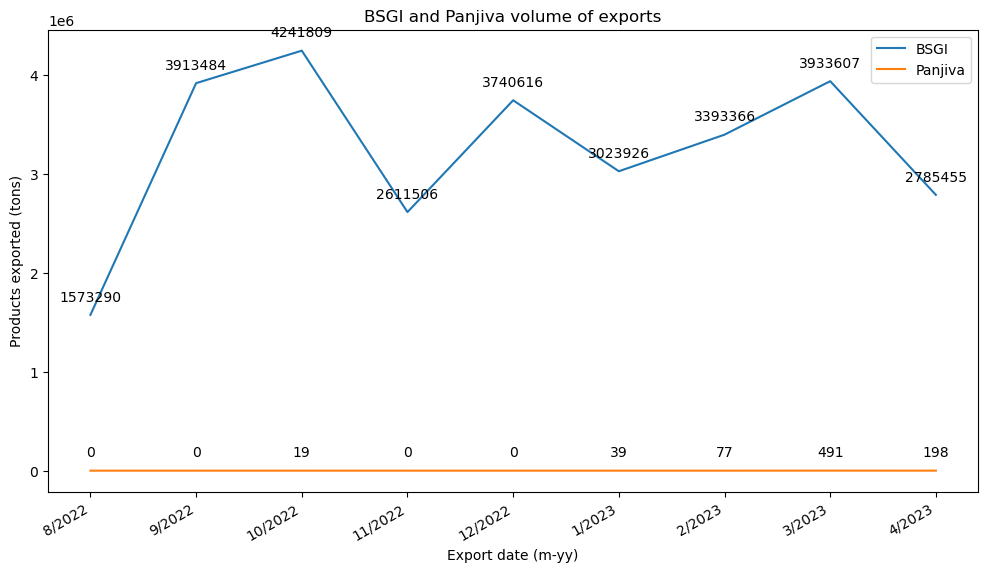

In [4]:
bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True)
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)

final = bsgi_g.merge(panjiva_g, on="date", suffixes=("_bsgi", "_panjiva"))
plot_line(final["date"], [final["weight_ton_bsgi"], final["weight_ton_panjiva"]], ["BSGI", "Panjiva"], "BSGI and Panjiva volume of exports", "Export date (m-yy)", "Products exported (tons)", False)

How many shipments do we have from January 2022 until now?

In [5]:
after_2022 = panjiva.loc[panjiva.loc[:, "date"] > "2022-01-01"]

print("Total date range from ", min(panjiva["date"]), " to ", max(panjiva["date"]))
print("Total shipments: ", len(panjiva))
print("Shipments from Jan 2022 until now: ", len(after_2022))
print("Share of shipments from Jan 2022 until now: ", round(len(after_2022) / len(panjiva) *100, 2), "%")
print("Share of date from Jan 2022 until now to total days: ", round((max(panjiva["date"]) - pd.Timestamp("2022-01-01")) / (max(panjiva["date"]) - min(panjiva["date"])) * 100, 2), "%")

Total date range from  2018-07-03 00:00:00  to  2023-04-28 00:00:00
Total shipments:  2705
Shipments from Jan 2022 until now:  616
Share of shipments from Jan 2022 until now:  22.77 %
Share of date from Jan 2022 until now to total days:  27.39 %


It doesn't seem like there aren't a lot of shipments. Let's check if the small export volume from January 2022 onwards is due to lack of data (NaN values) for weight of exports.

In [6]:
print("Number of NAs AFTER Jan 2022: ", sum(after_2022["weight_ton"].isna()))
print("Total observations: ", len(after_2022))
print("Share of NAs: ", round(sum(after_2022["weight_ton"].isna()) / len(after_2022) * 100, 2), "%")
print("Share of NAs: ", round(sum(after_2022["weight_ton"].isna()) / len(after_2022) * 100, 2), "%")

before_2022 = panjiva.loc[panjiva.loc[:, "date"] < "2022-01-01"]

print("Number of NAs BEFORE Jan 2022: ", sum(before_2022["weight_ton"].isna()))
print("Total observations: ", len(before_2022))
print("Share of NAs: ", round(sum(before_2022["weight_ton"].isna()) / len(before_2022) * 100, 2), "%")
print("Share of NAs: ", round(sum(before_2022["weight_ton"].isna()) / len(before_2022) * 100, 2), "%")

Number of NAs AFTER Jan 2022:  592
Total observations:  616
Share of NAs:  96.1 %
Share of NAs:  96.1 %
Number of NAs BEFORE Jan 2022:  1816
Total observations:  2085
Share of NAs:  87.1 %
Share of NAs:  87.1 %


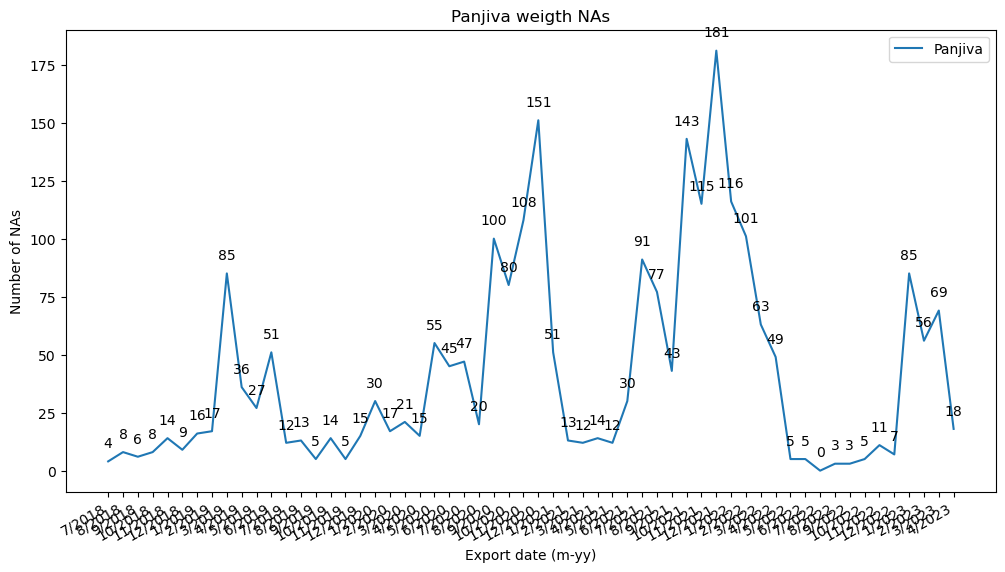

In [7]:
panjiva["na_bool"] = panjiva["weight_ton"].isna()
panjiva["na_bool"]

panjiva_g = cargo_grouping(panjiva, ["year", "month"], ["na_bool"], ["year", "month"], True)
panjiva_g["date"] = panjiva_g["month"].astype(str) + "/" + panjiva_g["year"].astype(str)
plot_line(panjiva_g["date"], [panjiva_g["na_bool"]], ["Panjiva"], "Panjiva weigth NAs", "Export date (m-yy)", "Number of NAs", False)

In [13]:
panjiva.loc[(panjiva.loc[:, "date"] > "2022-08-31") & (panjiva.loc[:, "date"] < "2022-10-01")][[ "date","weight_ton"]]

,date,weight_ton
8,2022-09-07,NaN
9,2022-09-06,NaN
66,2022-09-30,NaN


Record linkage between Panjiva and BSGI data to see if we can merge some shipments

Record linkage between Panjiva and Import Genius data to see if we can merge some shipments

In [9]:
# product_std = set(PRODUCTS_VAL)
    
# # We create a variable that sums the number of products mentioned in the
#     # product name
# crop_ig = ig.copy()
# crop_ig["n_products"] = 0

# for product in product_std:
#     crop_ig["n_products"] += crop_ig[product]

#     # Filter rows that only have the specified crop so we get more unique
#     # matches with the BSGI dataset
#     crop_ig = crop_ig.loc[(crop_ig.loc[:, crop] == True) &
#                           (crop_ig.loc[:, "n_products"] == 1)]
#     crop_bsgi = df_bsgi.loc[df_bsgi.loc[:, "product_std"] == "sunflower"]

#     translate_column(crop_bsgi, "country", "google", "en", "uk")
#     crop_bsgi = crop_bsgi.rename(columns={"country": "country_en", "country_gt": "country"})
#     clean_column(crop_bsgi, "country")

#     # Then we group the IG data by export date and country of destination because
#     # their data is more granular than the BSGI data.
#     crop_ig = crop_ig[["date", "country", "weight_ton"]]\
#                             .groupby(["date", "country"]).sum().reset_index()

#     crop_ig.index.name = "df_ig"
#     crop_bsgi.index.name = "df_bsgi"

#     matches = find_matches(crop_ig, crop_bsgi, ["date"], ["country"], ["date"])
    
#     # Create a unique matches index and filter the matches indexes by it to find
#     # unique matches
#     bsgi_i = matches.groupby("df_bsgi")["df_ig"].nunique()
#     unique = matches[matches["df_bsgi"].isin(bsgi_i[bsgi_i == 1].index)][["df_ig", "df_bsgi"]].reset_index(drop=True)

#     full_unique = unique.merge(crop_ig, left_on='df_ig', right_index=True)
#     full_unique = full_unique.merge(crop_bsgi, left_on='df_bsgi', right_index=True)

Number of matches:  15


/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/notebooks/../utils/clean_data.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column.lower() + "_gt"] = df[column].apply(lambda x: d[x])
